In [199]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


### Датасет выбрал из задачи Carvana на Kaggle. Но для упрощения для каждой модели автомобиля выбрал только по одной фотографии (ракурс по фронту). Таким образом, в используемом мной датасете 318 фотографий.

In [200]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Прочитаем списки наших файлов и отсортируем, чтобы каждой фотографии соответствовала своя маска

In [ ]:
import os, fnmatch
imag = os.listdir('/gdrive/My Drive/Colab Notebooks/nn_gb/6/train')
imag_label = os.listdir('/gdrive/My Drive/Colab Notebooks/nn_gb/6/train_masks')
imag.sort()
imag_label.sort()
for i in range(5):
  print(list(zip(imag,imag_label))[i])

('00087a6bd4dc_01.jpg', '00087a6bd4dc_01_mask.gif')
('02159e548029_01.jpg', '02159e548029_01_mask.gif')
('03a857ce842d_01.jpg', '03a857ce842d_01_mask.gif')
('0495dcf27283_01.jpg', '0495dcf27283_01_mask.gif')
('04bd942b463b_01.jpg', '04bd942b463b_01_mask.gif')


Задаю маршрут для чтения

In [ ]:
PAHT_label = '/gdrive/My Drive/Colab Notebooks/nn_gb/6/train_masks/'
PAHT_image = '/gdrive/My Drive/Colab Notebooks/nn_gb/6/train/'

#Загружаем и уменьшаем картинки

Опять упростил задачу,  взял непропорциональный, но подходящий размер,.

In [ ]:
images = []
segments = []
image_size = (200,200)

for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))

for i_name in imag_label:
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

Посмотрели на входные кадры

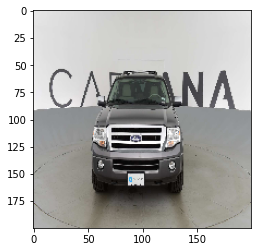

In [ ]:
plt.imshow(images[23].convert('RGBA'))
plt.show()

Посмотрим на цели

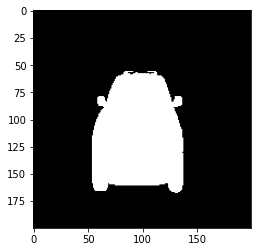

In [ ]:
plt.imshow(segments[23].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [ ]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [ ]:
print(xTrain_Test.shape)

(318, 200, 200, 3)


In [ ]:
import cv2

Делаем конвертер в one-hot_encoding для выходных примеров

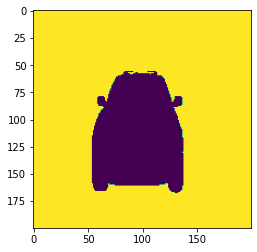

In [ ]:
def Color2index(y):
  arr_col=[[255,255,255],[0,0,0]]

  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1

cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[23]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

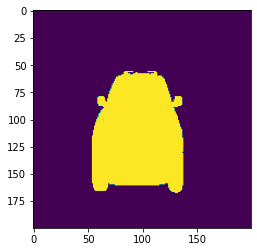

In [ ]:
plt.imshow(cat_yi[:,:,0])
plt.show()

Сегментированную картинку в  One hot encoding 

In [ ]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [ ]:
print(yTrain_Test.shape)

(318, 200, 200, 2)


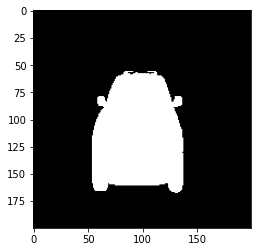

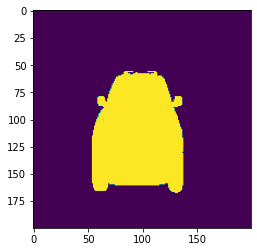

In [ ]:
n = 23
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [ ]:
N = 230
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [ ]:
print(xTest.shape)
print(yTest.shape)

(88, 200, 200, 3)
(88, 200, 200, 2)


In [ ]:
print(xTrain.shape)
print(yTrain.shape)

(230, 200, 200, 3)
(230, 200, 200, 2)


#Создаём и обучаем U-net

In [ ]:
from tensorflow.keras.utils import plot_model

**Unet**

In [ ]:
def cuttedUnet(num_classes = 2, input_shape= (200, 200, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 200, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_107 (BatchN (None, 200, 200, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_107 (Activation)     (None, 200, 200, 64) 0           batch_normalization_107[0][0]    
____________________________________________________________________________________________

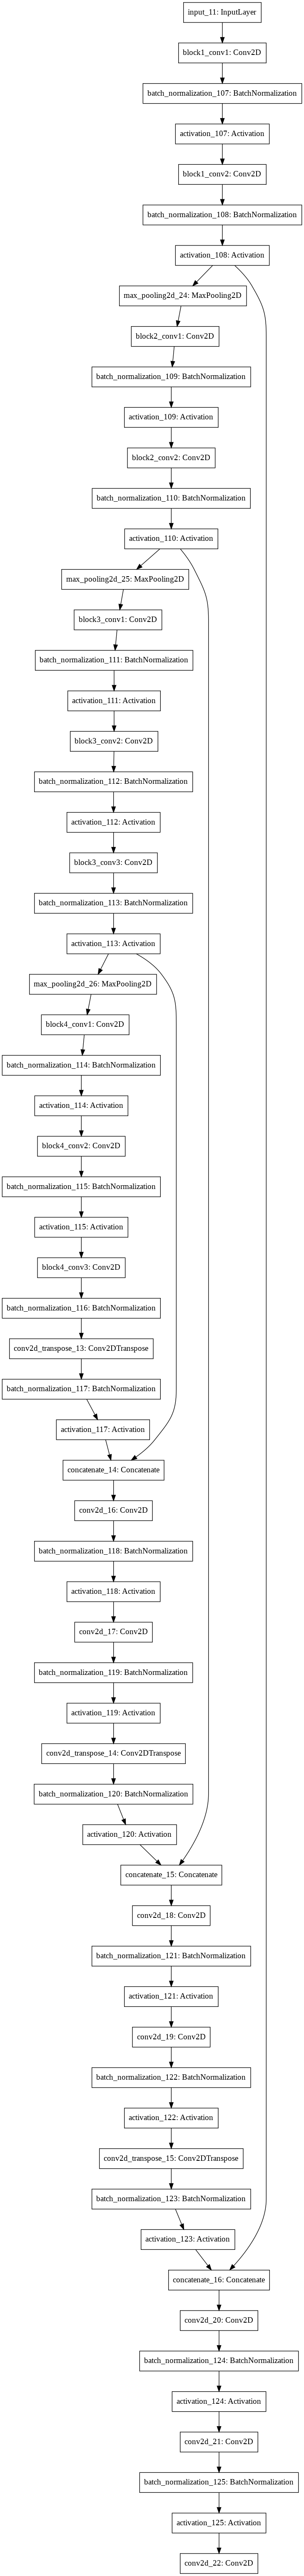

In [ ]:
modelC = cuttedUnet(2, (200, 200, 3))

plot_model(modelC, to_file='modelC.png')

In [ ]:

history = modelC.fit(xTrain, yTrain, epochs=15, batch_size=3, validation_data=(xTest, yTest))

Epoch 1/15
77/77 [==============================] - 14s 182ms/step - loss: 0.0110 - dice_coef: 0.9270 - val_loss: 0.0021 - val_dice_coef: 1.7346e-04
Epoch 2/15
77/77 [==============================] - 12s 161ms/step - loss: 0.0243 - dice_coef: 0.8629 - val_loss: 3.7483 - val_dice_coef: 0.6087
Epoch 3/15
77/77 [==============================] - 12s 162ms/step - loss: 0.0112 - dice_coef: 0.8843 - val_loss: 0.0806 - val_dice_coef: 0.8699
Epoch 4/15
77/77 [==============================] - 13s 163ms/step - loss: 0.0086 - dice_coef: 0.8972 - val_loss: 0.0152 - val_dice_coef: 0.8817
Epoch 5/15
77/77 [==============================] - 13s 163ms/step - loss: 0.0074 - dice_coef: 0.9096 - val_loss: 0.0127 - val_dice_coef: 0.8747
Epoch 6/15
77/77 [==============================] - 13s 164ms/step - loss: 0.0064 - dice_coef: 0.9191 - val_loss: 0.0155 - val_dice_coef: 0.8287
Epoch 7/15
77/77 [==============================] - 13s 164ms/step - loss: 0.0061 - dice_coef: 0.9202 - val_loss: 0.0090 - val

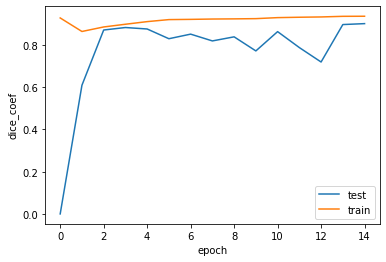

In [ ]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [ ]:
pred = modelC.predict(xTest)
print(pred.shape)

(88, 200, 200, 2)


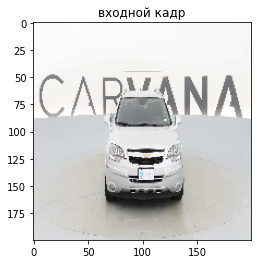

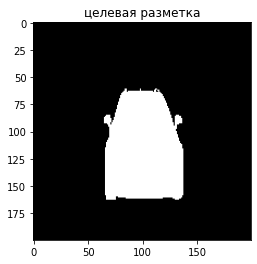

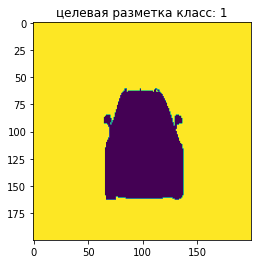

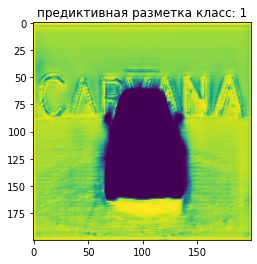

In [ ]:
n = 23
class_ =1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

**Претренированная  Unet**

In [201]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

In [202]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [203]:
def unet_pre_train(num_classes = 2, input_shape= (200, 200, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Tensor("block3_pool_3/Identity:0", shape=(None, 25, 25, 256), dtype=float32)
Tensor("block2_pool_3/Identity:0", shape=(None, 50, 50, 128), dtype=float32)
Tensor("block1_pool_3/Identity:0", shape=(None, 100, 100, 64), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 200, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 200, 200, 64) 36928       block1_conv1[0][0]               
__________________________________________________________

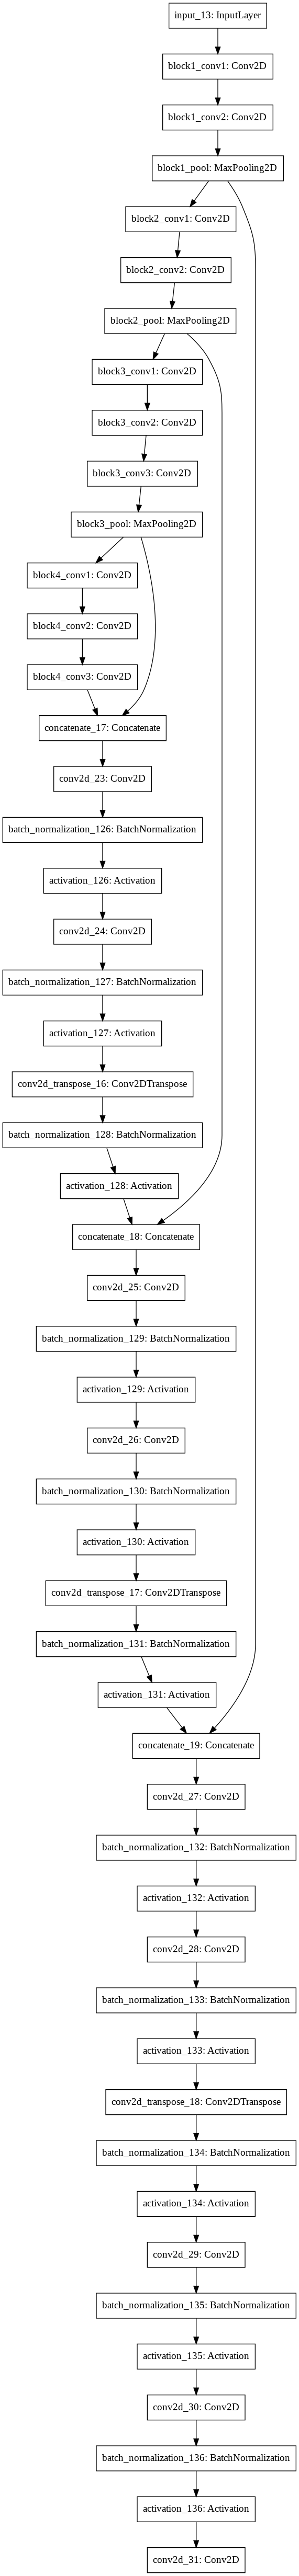

In [204]:
modelU = unet_pre_train(num_classes = 2, input_shape= (200, 200, 3))

plot_model(modelU, to_file='modelU.png')

In [205]:
history = modelU.fit(xTrain, yTrain, epochs=15, batch_size=3, validation_data=(xTest, yTest))

Epoch 1/15
77/77 [==============================] - 10s 132ms/step - loss: 0.1065 - dice_coef: 0.9382 - val_loss: 1.4226 - val_dice_coef: 0.5790
Epoch 2/15
77/77 [==============================] - 8s 105ms/step - loss: 0.0250 - dice_coef: 0.9850 - val_loss: 0.3834 - val_dice_coef: 0.8962
Epoch 3/15
77/77 [==============================] - 8s 105ms/step - loss: 0.0188 - dice_coef: 0.9890 - val_loss: 0.0760 - val_dice_coef: 0.9651
Epoch 4/15
77/77 [==============================] - 8s 105ms/step - loss: 0.0145 - dice_coef: 0.9915 - val_loss: 0.0328 - val_dice_coef: 0.9824
Epoch 5/15
77/77 [==============================] - 8s 106ms/step - loss: 0.0112 - dice_coef: 0.9933 - val_loss: 0.0175 - val_dice_coef: 0.9904
Epoch 6/15
77/77 [==============================] - 8s 106ms/step - loss: 0.0100 - dice_coef: 0.9940 - val_loss: 0.0110 - val_dice_coef: 0.9935
Epoch 7/15
77/77 [==============================] - 8s 107ms/step - loss: 0.0088 - dice_coef: 0.9947 - val_loss: 0.0113 - val_dice_coef

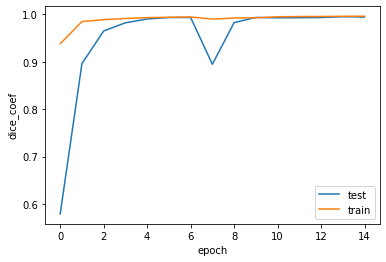

In [206]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [207]:
predu = modelU.predict(xTest)
print(pred.shape)


(88, 200, 200, 2)


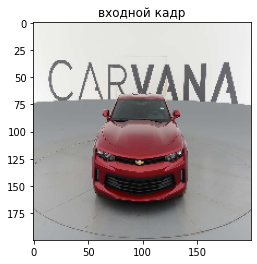

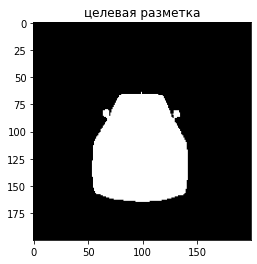

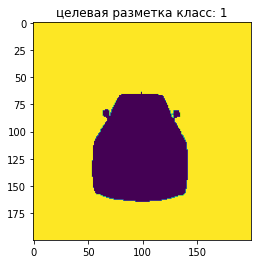

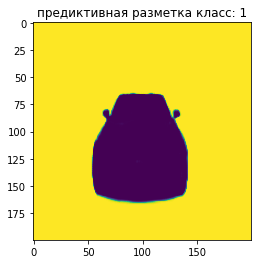

In [213]:
n = 1
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


### Вторая модель с применением VGG16 значительно улучшила результат